# **[LM2] Language modeling with RNN: GRU with Keras**

**Francesco Trono (221723)**

*University of Trento*

A.Y. 2020/2021 - Natural Language Understanding Course

francesco.trono@studenti.unitn.it

In [1]:
#Mounting Google Drive:
from google.colab import drive
drive.mount('/content/drive/', force_remount = False)

#Home directory:
%cd "/content/drive/My Drive/UniTrento/NLU/NLU_Project/Code"

Mounted at /content/drive/
/content/drive/My Drive/UniTrento/NLU/NLU_Project/Code


In [2]:
#Saved Penn-Treebank dataset:
ds_train = "../Src/ptb.train.txt"
ds_val = "../Src/ptb.valid.txt"
ds_test = "../Src/ptb.test.txt"

#INFERENCE-MODE TOGGLE:
#False to train GRU again.
#True to load weights saved during last training.
pretrained = True

In [3]:
#Libraries:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import random, squeeze, Tensor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model

**Part 1) Corpus processing & vectorization**

In [4]:
#CORPUS PROCESSING:
#accepts: directory of dataset file, vocabulary as dict (optional).
#returns: corpus as list of tokens, length of longest sentence.
def corpus_prepare(fdir, voc=None):
  f = open(fdir, "r")
  corpus = []
  l = 0
  longest = 0

  print("Preparing corpus...")

  for aline in f:
    aline = aline.strip()
    tokens = aline.split()
    corpus.append('<bos>')
    l = 1

    for tok in tokens:
      #if voc, align corpus to vocabulary (replace OOV):
      if voc:
        if tok not in voc.keys():
          corpus.append('<unk>')
        else:
          corpus.append(tok)
      else:
        corpus.append(tok)

      l = l+1
    if l > longest:
      longest = l

    corpus.append('<eos>')

  f.close()
  return corpus, longest

In [5]:
trn_corpus, trn_sl = corpus_prepare(ds_train)
print(trn_corpus[0:10])
print(trn_sl)

Preparing corpus...
['<bos>', 'aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman']
83


In [6]:
#2) Vocabulary extractor (tokens and integers):
#accepts: corpus.
#returns: vocabulary in dict format (words2ind), with tokens as keys and integers as values.
def get_vocab(corpus):
  #1) PRODUCE VOC & W2I:
  vocab = {}
  print("Extracting vocabulary from corpus...")

  #append default toks:
  vocab['<pad>'] = 0
  vocab['<unk>'] = 1
  vocab['<bos>'] = 2
  vocab['<eos>'] = 3
  i = 4

  for tok in corpus:
    if tok not in vocab.keys():
      vocab[tok] = i
      i = i+1

  #2: PRODUCE I2W:
  i2w = {}

  for k, v in vocab.items():
    i2w[v] = k

  return vocab, i2w

In [7]:
#voc is also the w2i vector:
voc, i2w = get_vocab(trn_corpus)

voc_w = list(voc.keys())
voc_i = list(voc.values())
vocl = len(voc_i)

print(voc)
print(vocl)
print(i2w)

Extracting vocabulary from corpus...
{'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3, 'aer': 4, 'banknote': 5, 'berlitz': 6, 'calloway': 7, 'centrust': 8, 'cluett': 9, 'fromstein': 10, 'gitano': 11, 'guterman': 12, 'hydro-quebec': 13, 'ipo': 14, 'kia': 15, 'memotec': 16, 'mlx': 17, 'nahb': 18, 'punts': 19, 'rake': 20, 'regatta': 21, 'rubens': 22, 'sim': 23, 'snack-food': 24, 'ssangyong': 25, 'swapo': 26, 'wachter': 27, 'pierre': 28, 'N': 29, 'years': 30, 'old': 31, 'will': 32, 'join': 33, 'the': 34, 'board': 35, 'as': 36, 'a': 37, 'nonexecutive': 38, 'director': 39, 'nov.': 40, 'mr.': 41, 'is': 42, 'chairman': 43, 'of': 44, 'n.v.': 45, 'dutch': 46, 'publishing': 47, 'group': 48, 'rudolph': 49, 'and': 50, 'former': 51, 'consolidated': 52, 'gold': 53, 'fields': 54, 'plc': 55, 'was': 56, 'named': 57, 'this': 58, 'british': 59, 'industrial': 60, 'conglomerate': 61, 'form': 62, 'asbestos': 63, 'once': 64, 'used': 65, 'to': 66, 'make': 67, 'kent': 68, 'cigarette': 69, 'filters': 70, 'has': 7

In [8]:
#converts the full dataset to integers vector on the basis of the vocabulary:
#accepts: vocabulary as dict, boolean to set the reading source (True for file, False for corpus), then either directory of dataset file or corpus to convert.
#returns: list of integers corresponding to vocabulary word indices.
def vectorize(voc, fromfile, fdir=None, corpus=None):
  
  #mode: read from input file:
  if fromfile == True:
    #if no file provided:
    if not fdir:
      return -1
    else:
      #read file:
      corpus, longest = corpus_prepare(fdir, voc)
  else:
    #mode: read from input corpus:
    if not corpus:
      return -1

  #vectorize:
  vectd = []
  i = 0

  for tok in corpus:
    if tok not in voc.keys():
      #replace with <unk>:
      vectd.append(1)
    else:
      vectd.append(voc[tok])

  if fromfile == True: 
    return vectd, longest
  else:
    return vectd 

In [9]:
#Vector converter from integers to tokens:
#accepts: vector of integers and i2w dict.
#returns: converted vector of tokens.
def deindexer(vect, i2w):
  #Init:
  conv = []

  for i in vect:
    conv.append(i2w[i])
  
  return conv

In [10]:
trn_vect = vectorize(voc, False, corpus=trn_corpus)
val_vect, val_sl = vectorize(voc, True, fdir=ds_val)
test_vect, test_sl = vectorize(voc, True, fdir=ds_test)

print(trn_vect[0:50])

trn_w = deindexer(trn_vect, i2w)
print(trn_w[0:50])

#MAX SEQUENCE SIZE:
print(trn_sl, val_sl, test_sl)
maxl = max(trn_sl, val_sl, test_sl)
print("MAX SENTENCE LENGTH: {}".format(maxl))

seq_size = 42
print("CHOSEN SEQUENCE LENGTH: {}".format(seq_size))

Preparing corpus...
Preparing corpus...
[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 3, 2, 28, 1, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 29, 3, 2, 41, 1, 42, 43, 44, 1]
['<bos>', 'aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>', '<bos>', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', '<eos>', '<bos>', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>']
83 75 78
MAX SENTENCE LENGTH: 83
CHOSEN SEQUENCE LENGTH: 42


**Part 2) Preparation of batches (model input & output)**

In [11]:
#split integer vector by sentence & sentence-level padding.
#accepts: vector of integers, seq_size (max length of sentences), type of vector (input or labels).
#returns: 1D vector with all sentences, already padded to seq_size, concatenated, to be easily split later by the batcher:
def prep_sentences(vect, seq_size, labels):

  buf = []
  vect_s = []
  last = 0

  #loop across tokens (int) in vector:
  for i in vect:
    #if buffer was reset before completion of the sentence (len of sentence > seq_size):
    if (len(buf) == 0) and (i != 2): #(2: '<bos>')
      #append last token first (for continuity):
      buf.append(last)

    #store current token in buffer:
    buf.append(i)
    last = i

    #stop buffer if index is 3 ('<eos>') or if reached seq_size length:
    if (i == 3) or (len(buf) == seq_size):
        #if preparing the labels vector:
        if labels == True:
          #the label y for each token in x is the next token x+1:
          buf = buf[1:]

        #Pad up to seq_size (adding 0: '<pad>'):
        buf_p = pad_sequences([buf], maxlen=seq_size, padding='post', value=0)
        vect_s.append(buf_p)
        buf = []
        buf_p = np.zeros(seq_size)

  vect_s = np.asarray(vect_s)
  vect_s = np.concatenate(vect_s, axis=None)

  return vect_s

In [12]:
batch_size = 64

#dataset preparation: calc x & y vectors & dataset-level padding, in order to allow obtaining batches of equal size.
#accepts: vector of integers, batch size & sequences size.
#returns: x & y ready for input to the model.
def prep_batches(vect, batch_size, seq_size):

  #1) sentence preparation: calc of x & y vectors & sentence-level padding:
  xv = prep_sentences(vect, seq_size, labels=False)
  yv = prep_sentences(vect, seq_size, labels=True)

  #2) Current full vect length (xv & yv have the same length):
  cur_l = len(xv)

  #3) Target vect length (to be divisible by batch_size * seq_size):
  #current min number of words per batch ("wpb" - round at lower integer):
  cur_wpb = cur_l // (batch_size * seq_size)
  #target min number of wpb: add one, to compensate for previous rounding to the lower integer:
  tgt_wpb = cur_wpb + 1
  #target vect length (pad up to this):
  tgt_l = tgt_wpb * batch_size * seq_size

  #4) Dataset-level padding: pad up to tgt_l (adding 0: '<pad>'):
  xp = pad_sequences([xv], maxlen=tgt_l, padding='post', value=0)
  yp = pad_sequences([yv], maxlen=tgt_l, padding='post', value=0)
  #The number of batches obtained will be divisible for batch_size thanks to this dataset-level padding.

  #5) Batches & sequences shaping:
  #For training dataset: xp & yp are <class 'numpy.ndarray'> of size (1, batch_size*seq_size).
  #I want now to split the dataset into sequences of seq_size tokens each:
  #(note: xp and yp have same size)
  batches = xp.shape[1] // seq_size #n batches obtainable
  #reshape:
  xp = np.reshape(xp, (batches, -1))
  yp = np.reshape(yp, (batches, -1))
  #new shape is (batch_size, seq_size).

  return xp, yp

In [13]:
#y as vectors of integers: will use sparse_categorical_crossentropy loss function.
x_trn, y_trn = prep_batches(trn_vect, batch_size, seq_size)
x_val, y_val = prep_batches(val_vect, batch_size, seq_size)
x_test, y_test = prep_batches(test_vect, batch_size, seq_size)

print(x_trn.shape)
print(y_trn.shape)

print(x_trn[0:5])
print(y_trn[0:5])

(43776, 42)
(43776, 42)
[[ 2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
  27  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 28  1 29 30 31 32 33 34 35 36 37 38 39 40 29  3  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 41  1 42 43 44  1 45 34 46 47 48  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 49  1 29 30 31 50 51 43 44 52 53 54 55 56 57 37 38 39 44 58 59 60 61
   3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 37 62 44 63 64 65 66 67 68 69 70 71 72 37 73 74 44 75 76 77 37 48 44
  78 79 66 80 81 82 29 30 83 84 85  3  0  0  0  0  0  0]]
[[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
   3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [28  1 29 30 31 32 33 34 35 36 37 38 39 40 29  3  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [41  1 42 43 44  1 45 34 46 47 48  3  0  0  0  0  0  0  0

**Part 3) Model building & training: GRU with Keras**

In [14]:
#Perplexity:
def perplexity(y_true, y_pred):
  #loss:
  sce = backend.sparse_categorical_crossentropy(y_true, y_pred)

  #shape of sce is a (64, 42) batch:
  #print(sce.get_shape())

  #I actually need the loss/perplexity averaged over all tokens within the batch: 
  #mean of batch loss:
  mean_sce = backend.mean(sce)
  #perplexity of batch:
  perplexity = backend.exp(mean_sce)
  
  return perplexity

In [15]:
#MODEL BUILDING:
#control pars:
hl_size = 500
drop_rate = 0.3
num_hl = 3

#model type:
model = Sequential()
#embedding layer:
model.add(Embedding(input_dim=vocl, output_dim=hl_size, batch_input_shape=(batch_size, seq_size), mask_zero=True))
model.add(Dropout(drop_rate))

#RNN: GRU layers:
for i in range(num_hl):
  model.add(Bidirectional(GRU(units=hl_size, return_sequences=True)))
  model.add(Dropout(drop_rate))

#softmax output layer:
model.add(TimeDistributed(Dense(vocl, activation="softmax")))

#print overview:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, 42, 500)             5001000   
_________________________________________________________________
dropout (Dropout)            (64, 42, 500)             0         
_________________________________________________________________
bidirectional (Bidirectional (64, 42, 1000)            3006000   
_________________________________________________________________
dropout_1 (Dropout)          (64, 42, 1000)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (64, 42, 1000)            4506000   
_________________________________________________________________
dropout_2 (Dropout)          (64, 42, 1000)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (64, 42, 1000)            4

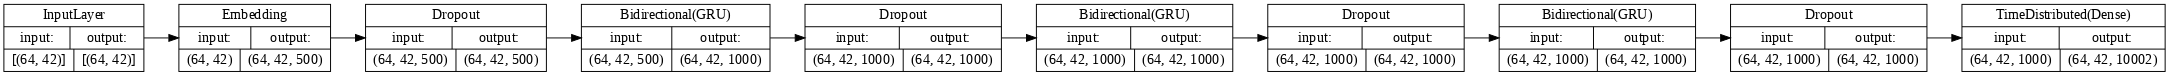

In [16]:
#print model graph:
plot_model(model, to_file='../Output/221723_GRU_model.png', rankdir='LR', show_shapes=True, show_dtype=False, show_layer_names=False, dpi=70)

In [17]:
epochs = 50

#optimizer:
opt = SGD(learning_rate=0.1, momentum=0.7, nesterov=True)

#early-stopping (Keras callback):
#monitor validation loss: stop after 3 consecutive epochs in which there is no improvement in val_loss:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#compile model:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy", perplexity])

In [ ]:
if pretrained == False:
  #train the model:
  GRU_history = model.fit(x_trn, y_trn, batch_size=batch_size, epochs=epochs,
                          callbacks=[early_stop], verbose=1, validation_data=(x_val, y_val))

  #save weights:
  model.save_weights('../Output/pretrained_GRU_weights')
  print("Weights saved.")

Epoch 1/50
684/684 [==============================] - 128s 162ms/step - loss: 3.4018 - accuracy: 0.1278 - perplexity: 2115.7119 - val_loss: 3.1677 - val_accuracy: 0.1388 - val_perplexity: 1475.5884
Epoch 2/50
684/684 [==============================] - 108s 158ms/step - loss: 3.0912 - accuracy: 0.1985 - perplexity: 1290.6193 - val_loss: 2.7481 - val_accuracy: 0.2914 - val_perplexity: 962.4863
Epoch 3/50
684/684 [==============================] - 106s 155ms/step - loss: 2.5322 - accuracy: 0.3406 - perplexity: 731.9887 - val_loss: 2.2608 - val_accuracy: 0.4029 - val_perplexity: 587.0703
Epoch 4/50
684/684 [==============================] - 107s 157ms/step - loss: 2.1801 - accuracy: 0.4302 - perplexity: 508.5527 - val_loss: 1.9685 - val_accuracy: 0.4767 - val_perplexity: 437.4848
Epoch 5/50
684/684 [==============================] - 106s 155ms/step - loss: 1.9306 - accuracy: 0.4888 - perplexity: 394.7058 - val_loss: 1.7482 - val_accuracy: 0.5278 - val_perplexity: 351.2261
Epoch 6/50
684/68

GRU - Training & validation loss:


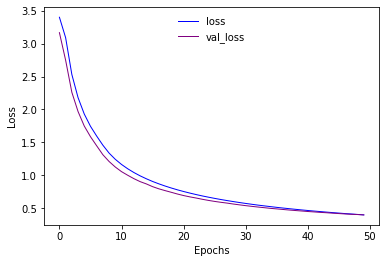


GRU - Training & validation perplexity:


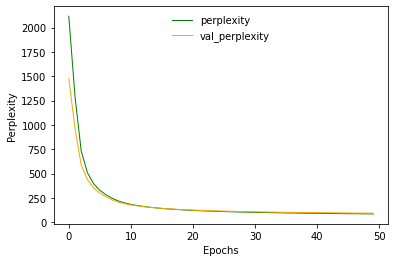

In [ ]:
#TRAINING & VALIDATION PROGRESS CHARTS:
#Access and plot GRU_history data using Matplotlib:
if pretrained == False:

  #CHART 1:
  print("GRU - Training & validation loss:")
  plt.figure(1)
  plt.plot(GRU_history.history['loss'], label='loss', color='blue', linewidth=1)
  plt.plot(GRU_history.history['val_loss'], label='val_loss', color='purple', linewidth=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=9, frameon=False)
  plt.show()

  #CHART 2:
  print("\nGRU - Training & validation perplexity:")
  plt.figure(2)
  plt.plot(GRU_history.history['perplexity'], label='perplexity', color='green', linewidth=1)
  plt.plot(GRU_history.history['val_perplexity'], label='val_perplexity', color='orange', linewidth=1)
  plt.xlabel('Epochs')
  plt.ylabel('Perplexity')
  plt.legend(loc=9, frameon=False)
  plt.show()

In [18]:
if pretrained == True:
  #load pretrained weights:
  model.load_weights('../Output/pretrained_GRU_weights')
  print("Pretrained weights loaded.")

Pretrained weights loaded.


**Part 4) Model evaluation & inference: text generation**

In [19]:
#evaluate:
inference = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

61/61 [==============================] - 17s 59ms/step - loss: 0.3504 - accuracy: 0.8886 - perplexity: 87.0826


In [ ]:
#accepts: vector of integers
#returns: integer
def generate_one_step(seed):
  #n of sentences to generate automatically inferred by length on input string.
  buf = []
  seed_size = len(seed)
  #input tensor:
  x_seeds = np.zeros(shape=(batch_size, seed_size))

  #convert seed to np array and add to empty input tensor:
  seed = np.asarray(seed, dtype=int)
  x_seeds[i, :] = seed

  #get unnormalized output probabilities (use model() for small data):
  pred_logits = model(x_seeds) #shape: (batch_size, seq_size, vocl)
  pred = pred_logits[-1] #take only last prediction

  #sample given the probabilities (logit):
  gen_samples = random.categorical(logits=pred, num_samples=1)
  #convert to list and save only 1st prediction:
  gen_samples = squeeze(gen_samples, axis=-1)
  gen_samples = np.asarray(gen_samples).tolist()
  gen = gen_samples[0]

  return gen

In [ ]:
#accepts: string
#returns: string
def generate_text(seeds, i2w, sent_length):

  my_sent_w = seeds.split()
  my_sent_i = vectorize(voc, False, corpus=my_sent_w)

  for i in range(sent_length):
    gen = generate_one_step(my_sent_i)
    my_sent_i.append(gen)

  my_sent_w = deindexer(my_sent_i, i2w)
  my_sent = ' '.join(my_sent_w)

  return my_sent

In [ ]:
#input seeds as list of strings:
seeds = ['but while the',
         'the N stock',
         'speculators are calling',
         'many money managers',
         'this confusion effectively']

print('Generating sentences...')
for s in seeds:
  my_sent = generate_text(s, i2w, sent_length=10)
  print(my_sent)

Generating sentences...
but while the tenure carried sensitive ahead league catastrophic action some buoyed earned
the N stock receives boesky sidewalk illustrates michelin emigration weekes burnham warrant electrical
speculators are calling pigs against shell george leverage incredible negotiator delayed motion verge
many money managers alleging glamorous presented impressed collect urge ultimate first-time casino massive
this confusion effectively seemingly kenneth prepared sat sen properties in-house downgrade competitors incident
